In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import glob
import gc
import functools
from multiprocessing import cpu_count,Pool
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
pd.options.display.max_columns=400
pd.options.display.max_rows=400


In [2]:
ROOT_DIR = '../data/instacart/files/'
out_of_fold = pd.read_csv(ROOT_DIR+'out_of_fold_preds.csv', usecols=['user_id', 'order_id', 'product_id', 'predicted'])
test_preds = pd.read_csv(ROOT_DIR+'test_preds.csv')
test_preds.rename(columns={'preds':'predicted'}, inplace=True)

In [3]:
prior = pd.read_csv(ROOT_DIR+'order_products__prior.csv', dtype={
    'order_id':np.int32,
    'product_id':np.uint16,
    'reordered':np.int8
}, usecols=['order_id', 'product_id', 'reordered'])

train = pd.read_csv(ROOT_DIR+'order_products__train.csv', dtype={
    'order_id':np.int32,
    'product_id':np.uint16,
    'reordered':np.int8
}, usecols=['order_id', 'product_id', 'reordered'])
orders = pd.read_csv(ROOT_DIR+'orders.csv', dtype={
    'order_id':np.int32,
    'user_id':np.int32,
    'eval_set':'category',
    'order_number':np.int16,
    'order_dow':np.int8,
    'order_hour_of_day':np.int8,
    'days_since_prior_order':np.float32
})

In [4]:
train = pd.merge(train, orders, on='order_id', how='left')
prior = pd.merge(prior, orders, on='order_id', how='left')

In [22]:
train['num_reordered'] = train.groupby(['order_id'])['reordered'].transform('sum')
prior['num_reordered'] = prior.groupby(['user_id', 'order_id'])['reordered'].transform('sum')

In [6]:
prior['avg_reorder_size'] = prior.groupby('user_id')['num_reordered'].transform('max').astype(np.int32)

None id 49689

In [7]:
def create_none(df, phase='train'):
    grouped_df = df.groupby(['user_id', 'order_id']) 
    none_prod = pd.DataFrame()
    none_prod['predicted'] = grouped_df['predicted'].apply(lambda x: np.prod(1-x))
    none_prod['product_id'] = 49689
    #if phase=='train':
    #    none_prod['reordered'] = grouped_df['reordered'].apply(lambda x: int(np.all(x==0)))
    #none_prod = none_prod[none_prod.reordered==1]
    none_prod.reset_index(inplace=True)
    return none_prod

In [8]:
none_prod = create_none(out_of_fold)
out_of_fold = pd.concat([out_of_fold, none_prod], axis=0)

#one_prod = create_none(test_preds, phase='test')
#test_preds = pd.concat([test_preds, none_prod], axis=0)
del none_prod

In [9]:
out_of_fold = pd.merge(out_of_fold, prior.drop_duplicates('user_id')[['user_id', 'avg_reorder_size']], how='left', on='user_id')

In [10]:
out_of_fold.sort_values(['order_id', 'predicted'],ascending=[True,False], inplace=True)

In [14]:
##### variable basket size implementation
def get_f1score(x, basket=20):
    user = x.user_id.unique()[0]
    #y_true = np.concatenate([x.loc[x.reordered==1, 'product_id']])
    y_true = train.loc[(train.user_id==user)&(train.reordered==1), 'product_id'].values
    if len(y_true) == 0:
        y_true = [49689]
    
    y_pred = x['product_id'].values[:x.avg_reorder_size.unique()[0]]
    # aggressive None handling
    #if np.sum(y_pred==49689)>0:
    #    y_pred = [49689]
    
    # moderate None handling - If None in top-5 
    #if np.sum(y_pred[:5]==49689)>0:
    #    y_pred = [49689]
    
    if len(y_pred) == 0:
        y_pred = [49689]
    
    precision = sum([1 for i in y_pred if i in y_true]) / float(len(y_pred))
    recall = sum([1 for i in y_true if i in y_pred]) / float(len(y_true))
    if precision + recall == 0:
        return 0
    return (2 * precision * recall) / float((precision + recall))

In [15]:
t = out_of_fold.groupby('order_id').apply(get_f1score)

In [16]:
t.mean()

0.3800876363982222

In [9]:
##### variable basket size implementation
def get_f1score(x, basket=20):
    user = x.user_id.unique()[0]
    #y_true = np.concatenate([x.loc[x.reordered==1, 'product_id']])
    y_true = train.loc[(train.user_id==user)&(train.reordered==1), 'product_id'].values
    if len(y_true) == 0:
        y_true = [49689]
    
    y_pred = x['product_id'].values[:basket]
    # aggressive None handling
    #if np.sum(y_pred==49689)>0:
    #    y_pred = [49689]
    
    # moderate None handling - If None in top-5 
    #if np.sum(y_pred[:5]==49689)>0:
    #    y_pred = [49689]
    
    if len(y_pred) == 0:
        y_pred = [49689]
    
    precision = sum([1 for i in y_pred if i in y_true]) / float(len(y_pred))
    recall = sum([1 for i in y_true if i in y_pred]) / float(len(y_true))
    if precision + recall == 0:
        return 0,0,0
    return precision, recall, (2 * precision * recall) / float((precision + recall))

In [11]:
##### variable threshold implementation

def get_f1score(x, threshold=0.15):

    user = x.user_id.unique()[0]
    #y_true = np.concatenate([x.loc[x.reordered==1, 'product_id']])
    y_true = train.loc[(train.user_id==user)&(train.reordered==1), 'product_id'].values
    if len(y_true) == 0:
        y_true = [49689]
    
    
    y_pred = np.concatenate([x.loc[x.predicted>=threshold, 'product_id']])
    #capping y_pred at 40 
    #precision is the only thing that can be controlled
    if len(y_pred) > 40:
        y_pred = np.concatenate([x.loc[x.predicted>=threshold, 'product_id']])[:40]
    #aggressive none handling
    if np.sum(y_pred==49689)>0:
        y_pred = [49689]
    if len(y_pred) == 0:
        y_pred = [49689]
    
    precision = sum([1 for i in y_pred if i in y_true]) / float(len(y_pred))
    recall = sum([1 for i in y_true if i in y_pred]) / float(len(y_true))
    if precision + recall == 0:
        return 0,0,0
    return precision, recall, (2 * precision * recall) / float((precision + recall))

In [12]:
# cutoff_1 = np.arange(0, 15, 2)
# cutoff_2 = np.arange(16, 32, 2)
cutoff_1 = np.arange(0, 0.01, 0.001)
cutoff_2 = np.arange(0.01, 0.34, 0.005)
cutoffs = np.concatenate([cutoff_1, cutoff_2])

f1_table = pd.DataFrame()
f1_table['user_id'] = np.sort(out_of_fold.user_id.unique())
def grid_f1(threshold):
    new_f1 = functools.partial(get_f1score, threshold=threshold)
    t = out_of_fold.groupby('user_id').apply(new_f1)
    #return np.expand_dims(t.values, axis=-1)
    return t.values

In [13]:
p = Pool(cpu_count())
f1_list = p.map(grid_f1, cutoffs)

In [14]:
precision=[]
recall=[]
f1=[]
for tup in f1_list:
    pr,re,f = zip(*tup)
    precision.append(list(pr))
    recall.append(list(re))
    f1.append(list(f))

In [15]:
precision = np.array(precision).T
recall = np.array(recall).T
f1= np.array(f1).T

In [16]:
f1_table['y_thr'] = cutoffs[np.argmax(f1, axis=1)]
f1_table['max_f1'] = np.max(f1, axis=1)
f1_table['precision_at_maxf1'] = precision[np.arange(131209), np.argmax(f1, axis=1)]
f1_table['recall_at_maxf1'] = recall[np.arange(131209), np.argmax(f1, axis=1)]

In [24]:
f1_table = pd.merge(f1_table, train.drop_duplicates('user_id')[['user_id', 'num_reordered']], on='user_id', how='left')

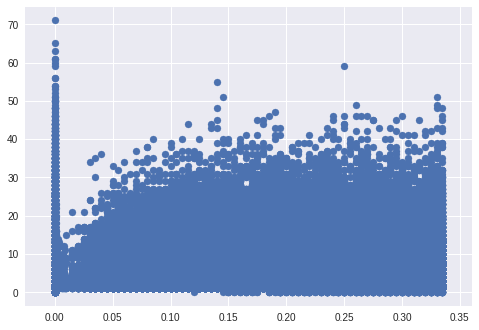

In [28]:
plt.figure()
plt.scatter(f1_table.y_thr,f1_table.num_reordered)
plt.show()

In [14]:
grouped_df = out_of_fold.groupby('user_id').size().reset_index()
f1_table = pd.merge(f1_table, grouped_df, on='user_id')

In [15]:
f1_table.rename(columns={0:'candidate_size'}, inplace=True)

In [16]:
out_of_fold = pd.merge(out_of_fold, f1_table, on='user_id', how='left')

In [17]:
#out_of_fold.tail(100)

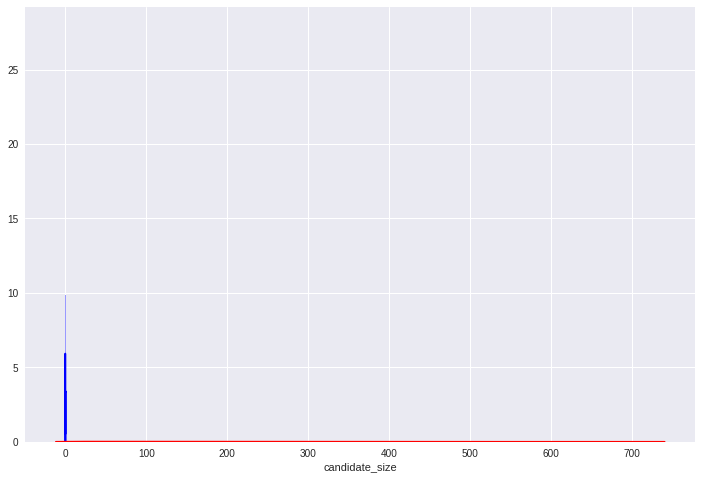

In [18]:
plt.figure(figsize=(12,8))
#fig,ax = plt.subplots(2, 1, figsize=(12,8))
sns.distplot(f1_table.y_thr,bins=60, color='blue')
sns.distplot(f1_table.candidate_size,bins=80, color='red')
plt.show()

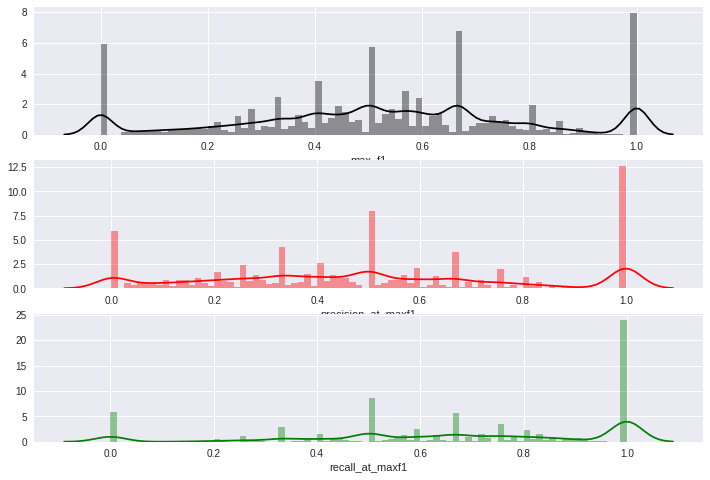

In [19]:
#plt.figure(figsize=(12,8))
fig,ax = plt.subplots(3, 1, figsize=(12,8))
sns.distplot(f1_table.max_f1,bins=80, color='black', ax=ax[0])
sns.distplot(f1_table.precision_at_maxf1, bins=80, color='red', ax=ax[1])
sns.distplot(f1_table.recall_at_maxf1, bins=80, color='green', ax=ax[2])
plt.show()

In [20]:
f1_table[f1_table.max_f1==0.5].head()

,user_id,y_thr,max_f1,precision_at_maxf1,recall_at_maxf1,candidate_size
3,7,0.27,0.5,0.500000,0.500000,69
8,14,0.13,0.5,0.500000,0.500000,143
9,17,0.25,0.5,0.400000,0.666667,84
18,37,0.17,0.5,0.666667,0.400000,105
24,46,0.13,0.5,0.357143,0.833333,63


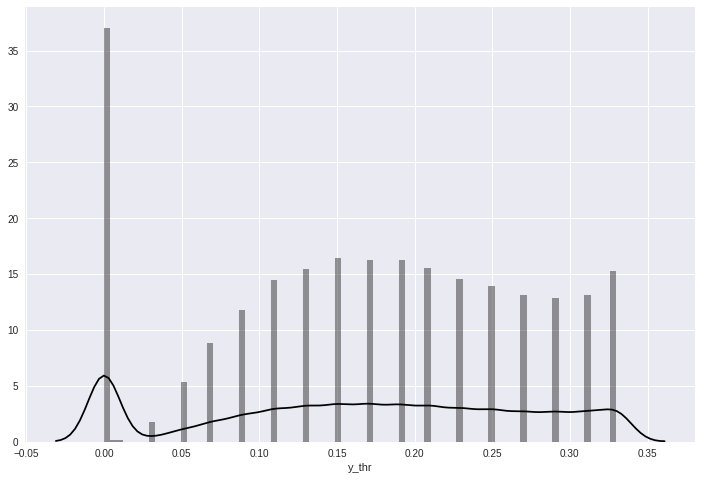

In [21]:
plt.figure(figsize=(12,8))
sns.distplot(f1_table.y_thr,bins=80, color='black')
plt.show()

In [22]:
f1_table.max_f1.mean()

0.5249099933828038

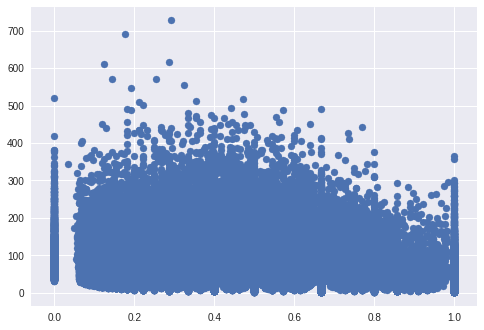

In [24]:
plt.figure()
plt.scatter(f1_table.max_f1,f1_table.candidate_size)
plt.show()

In [23]:
f1_table[f1_table.max_f1==0].head()

,user_id,y_thr,max_f1,precision_at_maxf1,recall_at_maxf1,candidate_size
6,10,0.0,0.0,0.0,0.0,95
27,49,0.0,0.0,0.0,0.0,46
38,66,0.0,0.0,0.0,0.0,19
76,116,0.0,0.0,0.0,0.0,22
90,138,0.0,0.0,0.0,0.0,56


In [15]:
#&(out_of_fold.reordered==1)
#&(out_of_fold.predicted>=out_of_fold.y_thr)
out_of_fold[(out_of_fold.user_id==182224)&(out_of_fold.reordered==1)]

,order_id,predicted,product_id,reordered,user_id,y_thr
1771711,1035125,0.007102,44815,1,182224,160


In [11]:
var = ['user_id', 'user_basket_size_in_last0_order','user_basket_size_in_last1_order','user_average_basket_size', 
       'user_reorder_rate', 'user_reorders', 'user_nb_orders','user_total_items', 'user_total_distinct_items', 
       'days_since_ratio', 'days_since_prior_order', 'user_average_days_between_orders','unique_aisles', 'unique_departments',
       'user_total_items_recent', 'user_total_distinct_items_recent','user_reorder_rate_recent', 'user_reorders_recent', 
       'user_average_days_between_orders_recent', 'user_average_basket_size_recent', 'order_hour_of_day', 'cumulative_time','days_since_cumulative_ratio'
       ,'user_order_velocity', 'user_days_since_prior_order_lag0', 'user_days_since_prior_order_lag1', 'days_since_prior_lag0_ratio', 'days_since_prior_lag1_ratio'
      ]
user_feat = pd.read_csv(ROOT_DIR+'cleaned_train/valid_onr_0.csv', usecols=var).drop_duplicates('user_id')

In [14]:
grouped_df = out_of_fold.groupby('user_id')
prob_feat = pd.DataFrame()
prob_feat['mean_prob'] = grouped_df['predicted'].mean()
prob_feat['sum_prob'] = grouped_df['predicted'].sum()
prob_feat.reset_index(inplace=True)

In [31]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=200,n_jobs=16,)
#user_feat = pd.merge(user_feat, prob_feat, on='user_id', how='left')
clf.fit(user_feat.sort_values('user_id')[var[1:]], f1_table.y_thr)

Process PoolWorker-28:
Traceback (most recent call last):
Process PoolWorker-25:
Traceback (most recent call last):
Process PoolWorker-22:
Process PoolWorker-21:
Process PoolWorker-26:
Process PoolWorker-23:
Traceback (most recent call last):
Process PoolWorker-24:
Process PoolWorker-27:
Traceback (most recent call last):
  File "/home/cvpr/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/cvpr/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cvpr/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/home/cvpr/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/cvpr/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/cvpr/anaconda2/lib/python2.7/multiprocessing/process.py", line

KeyboardInterrupt: 

In [24]:
clf.score(user_feat.sort_values('user_id')[var[1:]], f1_table.y_thr)

0.90324118299973744

In [27]:
grouped_df = test_preds.groupby('user_id')
prob_feat = pd.DataFrame()
prob_feat['mean_prob'] = grouped_df['predicted'].mean()
prob_feat['sum_prob'] = grouped_df['predicted'].sum()
prob_feat.reset_index(inplace=True)
test = pd.read_csv(ROOT_DIR + 'cleaned_test/test.csv', usecols=var)
test = pd.merge(test, prob_feat, on='user_id', how='left')
test['y_thr'] = clf.predict(test[var[1:]])

In [28]:
test_preds = pd.merge(test_preds, test[['user_id', 'y_thr']].drop_duplicates('user_id'), on='user_id', how='left')

In [29]:
def get_submission(x, threshold=0.2):
    y_pred = ' '.join(np.concatenate([x.loc[x.predicted>x.y_thr, 'product_id']]).astype(np.str))
    if len(y_pred) == 0:
        y_pred = 'None'
    if '49689' in y_pred.split(' '):
        y_pred = 'None'
    return y_pred

In [30]:
sub_df = test_preds.groupby('order_id').apply(get_submission).reset_index()
sub_df.columns = ['order_id', 'products']
sub_df.to_csv(ROOT_DIR+'none_handled_0.37.csv', index=False)

In [15]:
f1_table[f1_table.y_thr==0].head()

,user_id,y_thr
0,1,0.0
6,10,0.0
23,44,0.0
25,47,0.0
58,93,0.0


In [34]:
out_of_fold.groupby('y_thr')['predicted'].mean()

y_thr
0.000    0.089722
0.001    0.283404
0.002    0.212478
0.003    0.199579
0.004    0.116851
0.005    0.104051
0.006    0.130327
0.007    0.097147
0.008    0.101163
0.009    0.091132
0.010    0.068732
0.030    0.089065
0.050    0.091549
0.070    0.095337
0.090    0.097346
0.110    0.101331
0.130    0.105818
0.150    0.109439
0.170    0.113004
0.190    0.119369
0.210    0.122972
0.230    0.127897
0.250    0.131612
0.270    0.139319
0.290    0.140718
0.310    0.148214
0.330    0.150221
0.350    0.155211
0.370    0.161391
0.390    0.161757
Name: predicted, dtype: float64

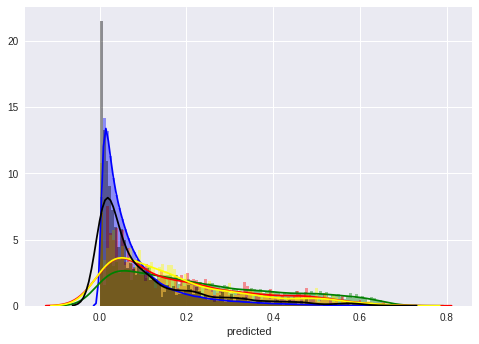

In [41]:
plt.figure()
sns.distplot(np.log1p(out_of_fold[out_of_fold.y_thr==0.0].predicted), bins=100, color='blue',)
sns.distplot(np.log1p(out_of_fold[out_of_fold.y_thr==0.001].predicted), bins=100, color='green')
sns.distplot(np.log1p(out_of_fold[out_of_fold.y_thr==0.002].predicted), bins=100, color='red')
sns.distplot(np.log1p(out_of_fold[out_of_fold.y_thr==0.003].predicted), bins=100, color='yellow')
sns.distplot(np.log1p(out_of_fold[out_of_fold.y_thr==0.004].predicted), bins=100, color='black')

In [18]:
h = out_of_fold.groupby(['order_id','y_thr']).size().reset_index()

In [19]:
h.groupby('y_thr')[0].mean()

y_thr
0       22.217402
1       27.578715
2       30.365602
3       33.259853
4       36.862949
5       39.795385
6       42.580110
7       45.152297
8       49.003550
9       49.969181
10      52.197393
20      61.689796
30      77.244044
40      89.314012
50     102.808359
60     114.807018
70     118.946429
80     127.662921
90     138.653061
100    143.714286
110    163.142857
120    159.625000
130    172.333333
140    184.125000
150    171.000000
160    191.666667
170    221.333333
180    233.000000
Name: 0, dtype: float64

In [18]:
h = out_of_fold.groupby(['order_id','y_thr']).size().reset_index()

lower candidate size causes lower threshold

In [19]:
h.groupby('y_thr')[0].mean()

y_thr
0.000    20.118413
0.001    55.200000
0.002    79.000000
0.003    64.500000
0.004    83.540541
0.005    75.326531
0.006    52.578125
0.007    57.214286
0.008    50.240310
0.009    47.835681
0.010    70.258883
0.030    43.231092
0.050    42.526066
0.070    41.759450
0.090    44.335076
0.110    44.849292
0.130    45.998349
0.150    47.072110
0.170    48.377059
0.190    48.255733
0.210    48.711837
0.230    48.787592
0.250    48.521910
0.270    48.579611
0.290    48.922615
0.310    48.027419
0.330    47.453794
0.350    48.779298
0.370    49.018621
0.390    53.696802
Name: 0, dtype: float64

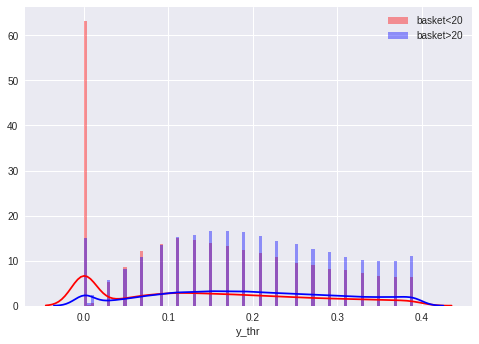

In [23]:
plt.figure()
sns.distplot(h[h[0]<=20].y_thr,bins=100, color='red', label='basket<20')
sns.distplot(h[h[0]>20].y_thr,bins=100, color='blue', label='basket>20')
plt.legend(loc='best')
plt.show()

In [26]:
var = ['user_id', 'user_basket_size_in_last0_order','user_basket_size_in_last1_order','user_average_basket_size', 
       'user_reorder_rate', 'user_reorders', 'user_nb_orders','user_total_items', 'user_total_distinct_items', 
       'days_since_ratio', 'days_since_prior_order', 'user_average_days_between_orders', 'unique_aisles', 'unique_departments',
       'user_total_items_recent', 'user_total_distinct_items_recent','user_reorder_rate_recent', 'user_reorders_recent', 
       'user_average_days_between_orders_recent', 'user_average_basket_size_recent', 'order_hour_of_day', 'cumulative_time','days_since_cumulative_ratio'
       ,'user_order_velocity', 'days_since_prior_order_lag1', 'days_since_prior_order_lag2', 'days_since_prior_lag1_ratio', 'days_since_prior_lag2_ratio'
      ]
train = pd.read_csv(ROOT_DIR+'cleaned_train/valid_onr_0.csv', usecols=var).drop_duplicates('user_id')

order_id
38     0.0
226    0.0
456    0.0
719    0.0
774    0.0
dtype: float64

In [32]:
np.arange()

array([ 0.00100231,  0.00101605,  0.00102998,  0.00104411,  0.00105843,
        0.00107294,  0.00108766,  0.00110257,  0.00111769,  0.00113302,
        0.00114856,  0.00116431,  0.00118027,  0.00119646,  0.00121287,
        0.0012295 ,  0.00124636,  0.00126345,  0.00128078,  0.00129834,
        0.00131615,  0.0013342 ,  0.00135249,  0.00137104,  0.00138984,
        0.0014089 ,  0.00142822,  0.00144781,  0.00146767,  0.00148779,
        0.0015082 ,  0.00152888,  0.00154984,  0.0015711 ,  0.00159264,
        0.00161448,  0.00163662,  0.00165907,  0.00168182,  0.00170488,
        0.00172826,  0.00175196,  0.00177599,  0.00180035,  0.00182503,
        0.00185006,  0.00187543,  0.00190115,  0.00192722,  0.00195365,
        0.00198044,  0.0020076 ,  0.00203513,  0.00206304,  0.00209134,
        0.00212002,  0.00214909,  0.00217856,  0.00220844,  0.00223872])